**Index**

1. [Problem Formulation](#P1)
2. [Machine Learning Pipeline](#P2)
3. [Transformation Stage](#P3)
4. [Modelling](#P4)
5. [Methodology](#P5)
6. [Dataset](#P6)
7. [Results](#P7)
8. [Conclusion](#P8)



<a id='P1'></a>

# 1 Problem Formulation

Can a machine classify whether an audio recording has been recorded in an area with relatively high Air Pollution Index?

It will be interesting to see whether a machine can pick up some distinctive pattern within the features and decide whether the filming location has relatively high Air Pollution Index (value of 2) or relatively low Air Pollution Index (value of 1).

<a id='P2'>

# 2 Machine Learning Pipeline

Based on the audio samples taken from the MLEnd dataset, I intend to build a machine learning pipeline that takes as an input an audio segment and extracts the power, the pitch and the fraction of voiced region. Moreover, from the pitch the pipeline will extract additional features such as: pitch_mean, pitch_std, pitch_1q, pitch_3q, pitch_iqr.

All features extracted will be turned into a 7 feature long NumPy predictor array which will be passed through a model for training purposes. Based on what the model has learnt, a validation set will be passed through the trained model that will output a label prediction of the type of filming spot, i.e. high Air Pollution Index or low Air Pollution Index.

<a id='P3'>

# 3 Transformation Stage

Each audio sample consists of 100,000s of features which would make this task computationally impossible both in terms of the sample size and processing time. 

Thus, to make this problem more computationally viable, I will use a pipeline that takes as an input an audio segement and transforms it into a 7 feature long NumPy predictor array consisting of: power, pitch_mean, pitch_std, pitch_1q, pitch_3q, pitch_iqr, voiced_fr. 

Hence, instead of having 100,000s of features per audio segment, I will have 7 features per audio segment. As a result, I will no longer need 100,000s of samples to train my models to avoid overfitting, but instead I will only need more than 7 samples. This will decrease both the dataset requirement and processing time.

<a id='P4'>

# 4 Modelling

To find an answer to the proposed problem I will build multiple supervised classification models that will use the features described above to identify the type of filming spot, i.e. high Air Pollution Index or low Air Pollution Index. 

The reason why I have chosen to build supervised classification models is because the label of each audio recording will be known and the label that I am aiming to predict is discrete.

The models that I will build are as follows: Support vector machine (SVM), Linear Support vector machine, Stochastic Gradient Descent (SGD), Gaussian Process Classification (GPC), Decision Tree, and Neural network model.

By builiding multiple models, I will be able to compare multiple performances and pick the model that best predicts the label.

<a id='P5'>

#5 Methodology

To train and validate my models I will first split my dataset into a 70-30 split where 70% of the samples will be used to train each model and 30% of the samples will be used to validate each model.

To assess a model's performance I will use a combination of accuracy measures and a confusion matrix. This will allow me to visually inspect the performance of each model which will not be picked up by the standard accuracy measures. 

The best model will be the model that doesn't bias any of the two labels i.e. doesn't label everything as being recorded in high Air Pollution Index area or low Air Pollution Index area whilst maintaining high accuracy.

<a id='P6'>

# 6 Dataset

Due to the limited computing power, I intend to use 500 audio samples taken from the MLEndLS_2.zip file. Out of these 500 samples, I will use 350 samples for training and 150 for validation.

Alongside the 500 samples, I will also use a CSV file with the correct labels to both train the models and assess the performance during the validation stage.

To label my samples I will use pollution levels from 30/11/2022 displayed on the following website:

https://www.londonair.org.uk/london/asp/publicbulletin.asp?region=0&site=&bulletin=daily&bulletindate=30/11/2022&la_id=&postcode=&level=All&MapType=Google&VenueCode=

If there is no Air Pollution Index displayed in a specific filming spot, I will assign a pollution index that is the closest to that filming spot.

Since air quality in London is generally very good, the index on 30/11/2022 goes as high as 2 on a scale of 1-10. Therefore, the Air Pollution Index of 2 is relatively high compared to areas with the Air Pollution Index of 1.

# Importing useful Python libraries and mounting my personal Google Drive

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


# Loading the dataset

Extracting audio samples from a zipped file called 'MLEndLS_2.zip':

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEndLS/project/'
zip_path = '/content/drive/MyDrive/Data/MLEndLS/MLEndLS_2.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Checking the number of audio samples:



In [ ]:
sample_path = '/content/drive/MyDrive/Data/MLEndLS/project/*.wav'
files = glob.glob(sample_path)
len(files)

500

Visualising one of the audio samples:

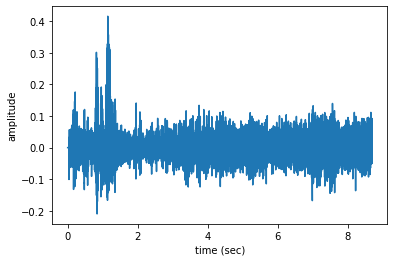

In [ ]:
n=0
fs = None # Sampling frequency
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

Uploading the CSV file 'MLEndLS_Sample.csv' with all samples and loading it into a Pandas DataFrame. 

This DataFrame will be used to get the pollution level label that corresponds to each audio sample loaded from 'MLEndLS_2.zip'.

In [ ]:
MLENDLS_df = pd.read_csv('./MLEndLS.csv').set_index('file_id')
MLENDLS_df

,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176
...,...,...,...,...
2496.wav,westend,trafalgar,outdoor,S151
2497.wav,campus,square,outdoor,S6
2498.wav,westend,national,indoor,S96


Creating a new column with pollution level labels.

Areas such as southbank, british, and Euston are assigned the label 'High' because the closest pollution index to the recording spots is 2.

Areas such as kensington, campus, and westend are assigned the label 'Low' because the closest pollution index to the recording spots is 1.

In [ ]:
def pollution_level(area):
  if (area == "southbank") or (area == "british") or (area == "Euston"):
    return "High"
  else:
    return "Low"

MLENDLS_df["Pollution_Level"] = MLENDLS_df["area"].map(pollution_level)
MLENDLS_df

,area,spot,in_out,Participant,Pollution_Level
file_id,,,,,
0001.wav,british,street,outdoor,S151,High
0002.wav,kensington,dinosaur,indoor,S127,Low
0003.wav,campus,square,outdoor,S18,Low
0004.wav,kensington,hintze,indoor,S179,Low
0005.wav,campus,square,outdoor,S176,Low
...,...,...,...,...,...
2496.wav,westend,trafalgar,outdoor,S151,Low
2497.wav,campus,square,outdoor,S6,Low
2498.wav,westend,national,indoor,S96,Low


As previously stated, each audio sample consists of 100,000s of features as shown below:

In [ ]:
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 383669 samples


Therefore, to reduce the dimensionality of each sample I will pass each audio sample through the following pipeline.

# Preprocessing

Defining a function that extracts the pitch of the audio sample:

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs, frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

Defining a function that takes a collection of audio samples together with a 'MLENDLS_df' DataFrame and creates a NumPy array containing the 7 audio features used as predictors (X) and a binary label (y) that indicates whether the recording is high (y=1) or low (y=0):

In [ ]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['Pollution_Level']=='High'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_1q = np.nanquantile((f0) if np.mean(np.isnan(f0))<1 else 0, 0.25)
    pitch_3q = np.nanquantile((f0) if np.mean(np.isnan(f0))<1 else 0, 0.75)
    pitch_iqr = pitch_3q - pitch_1q

    voiced_fr = np.mean(voiced_flag)

    xi = [power, pitch_mean, pitch_std, pitch_1q, pitch_3q, pitch_iqr, voiced_fr]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

Applying the getXy function to the audio samples and obtaining the NumPy predictor array (X) and a binary label (y):

In [ ]:
X,y = getXy(files, labels_file=MLENDLS_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 500/500 [14:02<00:00,  1.69s/it]


The NumPy predictor array (X) of the first audio sample:

In [ ]:
X[0]

array([6.67637168e-03, 1.09549980e+02, 3.49022286e+00, 1.07405800e+02,
       1.11837595e+02, 4.43179451e+00, 2.80000000e-02])

The binary label (y) of the first audio sample:

In [ ]:
y[0]

False

The shape of X and y:

In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (500, 7)
The shape of y is (500,)


As you can see, we have 500 items consisting of 7 features (stored in X) and one binary label (stored in y). 

Let's check if the dataset is balanced:

In [ ]:
print(' The number of high pollution recordings is ', np.count_nonzero(y))
print(' The number of low pollution recordings is ', y.size - np.count_nonzero(y))

 The number of high pollution recordings is  165
 The number of low pollution recordings is  335


The difference between the number of high and low samples is 170. 

This difference is significant and will effect the outcome of model training. Therefore, I will try to take this into consideration when building each model.

<a id='P7'>

# 7 Results

Importing the necessary libraries to build models:

In [ ]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier

Splitting the dataset defined by X and y into a training set and a validation set:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((350, 7), (150, 7), (350,), (150,))

350 samples will be used to train my models and 150 samples will be used for validation.

Creating a function that will create a visually appealing confusion matrix:

In [ ]:
from sklearn import metrics

def confusion_matrix_heatmap(true_y, predicted_y, labels):
    cm = metrics.confusion_matrix(true_y, predicted_y, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.show()
    plt.show()

# Support vector machine (SVM)

To take into account the imbalance of high and low samples I set the 'class_weight' parameter to be balanced:

In [ ]:
model  = svm.SVC(C=1, class_weight="balanced")
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5914285714285714
Validation Accuracy 0.5333333333333333


In [ ]:
true_y = y_val
predicted_y = yv_p
labels = [True, False]

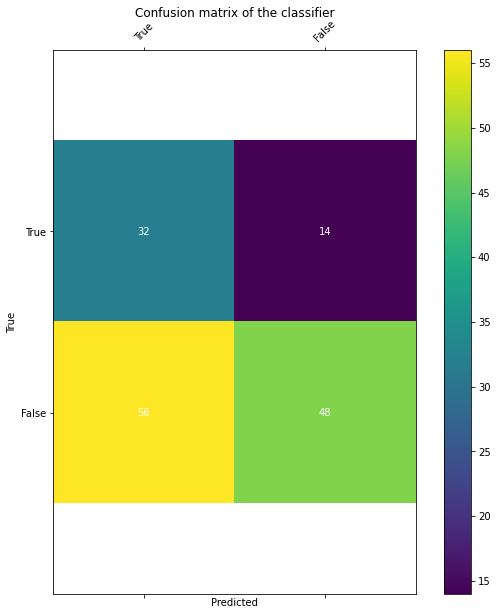

In [ ]:
#True = high, False = low
confusion_matrix_heatmap(true_y, predicted_y, labels)

By solely looking at the accuracy statistics it can be concluded that the SVM model can accurately predict the correct label with 53.3% accuracy.

However, by a closer inspection of the confusion matrix, the model misclassifies a lot of False samples as True (false-positive). This means that the model has some troubles with recognising False samples.


Next, I will normalise the predictors to see if the performance improves.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1,gamma=2, class_weight="balanced")
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.8285714285714286
Validation Accuracy 0.6133333333333333


In [ ]:
true_y = y_val
predicted_y = yv_p
labels = [True, False]

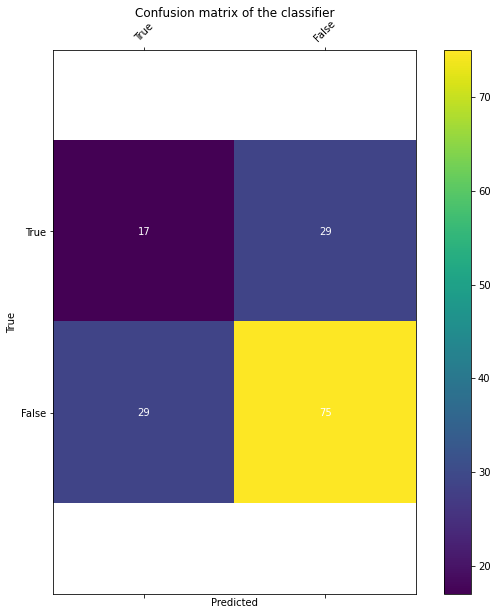

In [ ]:
#True = high, False = low
confusion_matrix_heatmap(true_y, predicted_y, labels)

Normalisation of the predictors did improve the performance. 

The accuracy statistics increased to 61.3%. However, the confusion matrix shows that despite a substantial reduction in false-positive samples, there is also a substantial reduction in true-positive samples that became false-negative. This shows that despite taking into consideration the imbalance in the high and low samples, the model assigns a False label more often.

# Linear Support vector machine (SVM)

To take into account the imbalance of high and low samples I set the 'class_weight' parameter to be balanced:



In [ ]:
model = svm.LinearSVC(class_weight="balanced")
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5714285714285714
Validation Accuracy 0.5666666666666667


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
true_y = y_val
predicted_y = yv_p
labels = [True, False]

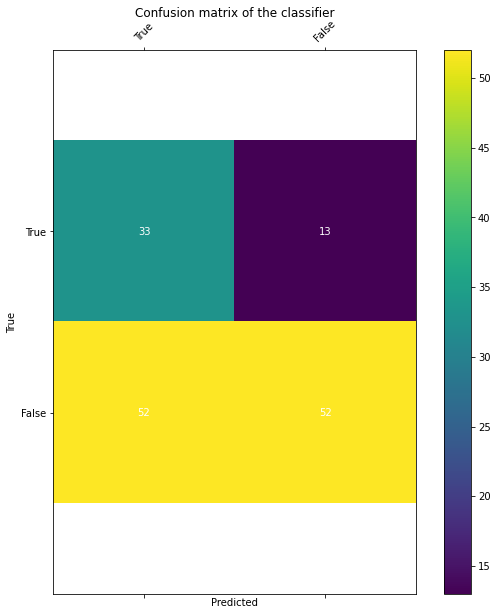

In [ ]:
#True = high, False = low
confusion_matrix_heatmap(true_y, predicted_y, labels)

The accuracy statistics show that the Linear SVM model accurately predicts the label 56.7% of the time.

However, by a closer inspection of the confusion matrix, the model misclassifies a lot of False samples as True (false-positive). This means that the model has troubles with recognising False samples.

Next, I will normalise the predictors to see if the performance improves.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model = svm.LinearSVC(class_weight="balanced")
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5685714285714286
Validation Accuracy 0.58


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
true_y = y_val
predicted_y = yv_p
labels = [True, False]

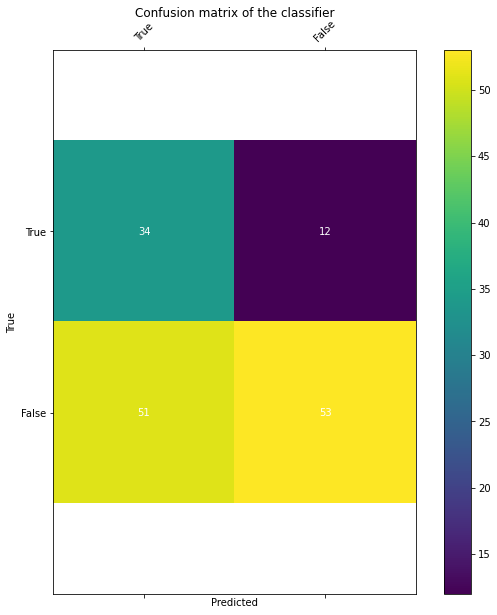

In [ ]:
#True = high, False = low
confusion_matrix_heatmap(true_y, predicted_y, labels)

Normalisation of the predictors slightly improved the performance.

The accuracy statistics increased to 58%. This increase can be explained by a slight increase in the number of correctly predicted labels as both true-positive and true-negative increased by 1.

# Stochastic Gradient Descent (SGD)

To take into account the imbalance of high and low samples I set the 'class_weight' parameter to be balanced:


In [ ]:
model = SGDClassifier(loss="hinge", penalty="l2", max_iter=10, class_weight="balanced")
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5771428571428572
Validation Accuracy 0.58


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [ ]:
true_y = y_val
predicted_y = yv_p
labels = [True, False]

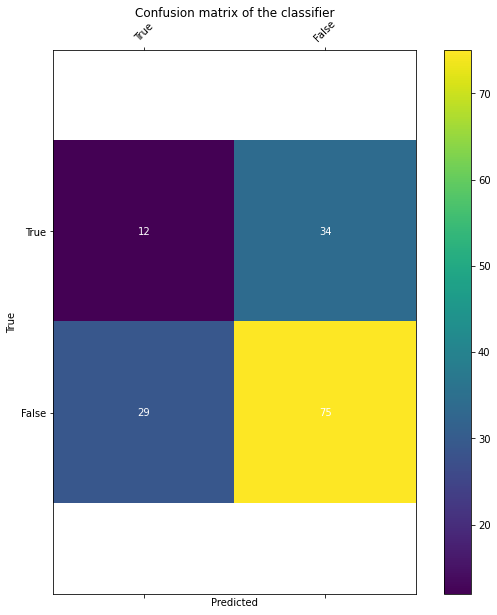

In [ ]:
#True = high, False = low
confusion_matrix_heatmap(true_y, predicted_y, labels)

The accuracy statistics show that the SGD model accurately predicts the label 58% of the time.

However, by a closer inspection of the confusion matrix, the model assigns a False label to the majorty of the samples. This means that the model has troubles with recognising True samples.

Next, I will normalise the predictors to see if the performance improves.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model = SGDClassifier(loss="hinge", penalty="l2", max_iter=10, class_weight="balanced")
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5085714285714286
Validation Accuracy 0.42


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [ ]:
true_y = y_val
predicted_y = yv_p
labels = [True, False]

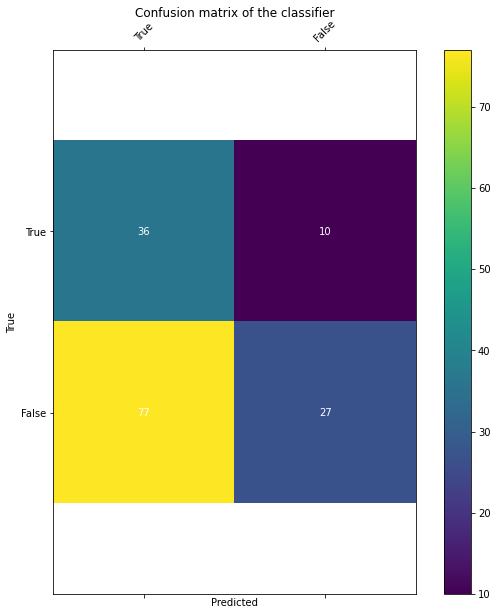

In [ ]:
#True = high, False = low
confusion_matrix_heatmap(true_y, predicted_y, labels)

Normalisation of the predictors did not improve the performance.

The accuracy statistics fell to 42% and the confusion matrix shows that the model now assigns a True label to the majority of samples.

# Gaussian Process Classification (GPC)

Unfortunately, this model does not have a parameter that will take into consideration an imbalance in the samples.

In [ ]:
model = GaussianProcessClassifier()
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.7485714285714286
Validation Accuracy 0.7066666666666667


In [ ]:
true_y = y_val
predicted_y = yv_p
labels = [True, False]

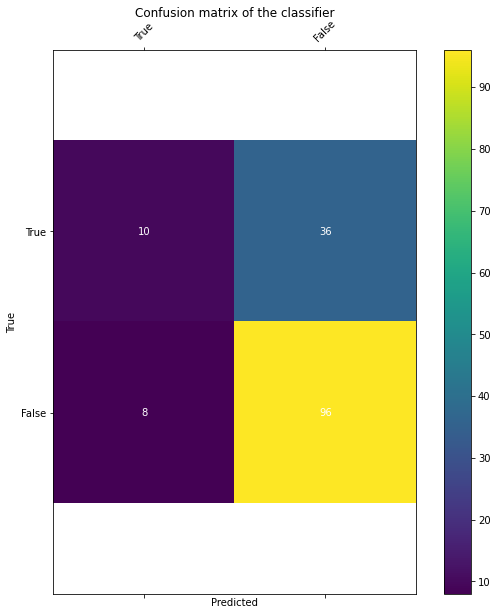

In [ ]:
#True = high, False = low
confusion_matrix_heatmap(true_y, predicted_y, labels)

The accuracy statistics show that the GPC model accurately predicts the label 70.7% of the time.

However, by a closer inspection of the confusion matrix, the model assigns a False label to the majority of the samples. This means that the model has troubles with recognising True samples. This is understandable as there are fewer True samples to train on so the model has less opporunities to learn about what to look out for in the True samples.

Next, I will normalise the predictors to see if the performance improves.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model = GaussianProcessClassifier()
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.7485714285714286
Validation Accuracy 0.7066666666666667


In [ ]:
true_y = y_val
predicted_y = yv_p
labels = [True, False]

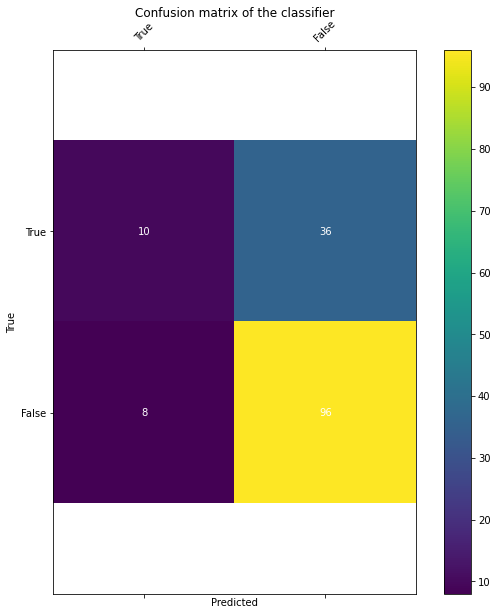

In [ ]:
#True = high, False = low
confusion_matrix_heatmap(true_y, predicted_y, labels)

Normalisation of the predictors did not improve the performance.

Both accuracy statistics and the confusion matrix remain unchanged.

# Decision Tree

To take into account the imbalance of high and low samples I set the 'class_weight' parameter to be balanced:


In [ ]:
model = tree.DecisionTreeClassifier(class_weight="balanced")
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 1.0
Validation  Accuracy 0.5333333333333333


In [ ]:
true_y = y_val
predicted_y = yv_p
labels = [True, False]

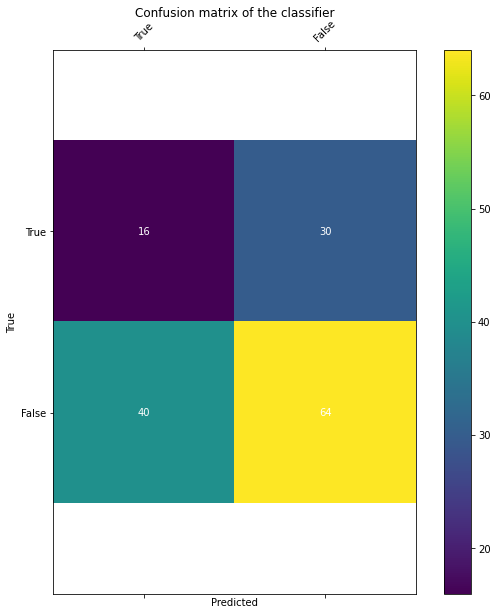

In [ ]:
#True = high, False = low
confusion_matrix_heatmap(true_y, predicted_y, labels)

The accuracy statistics show that the Decision Tree model accurately predicts the label 53.3% of the time.

However, by a closer inspection of the confusion matrix, the model assigns more False labels than True labels. This means that the model has troubles with indentifying True samples.

Next, I will normalise the predictors to see if the performance improves.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model = tree.DecisionTreeClassifier(class_weight="balanced")
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))

Training Accuracy 1.0
Validation Accuracy 0.5133333333333333


In [ ]:
true_y = y_val
predicted_y = yv_p
labels = [True, False]

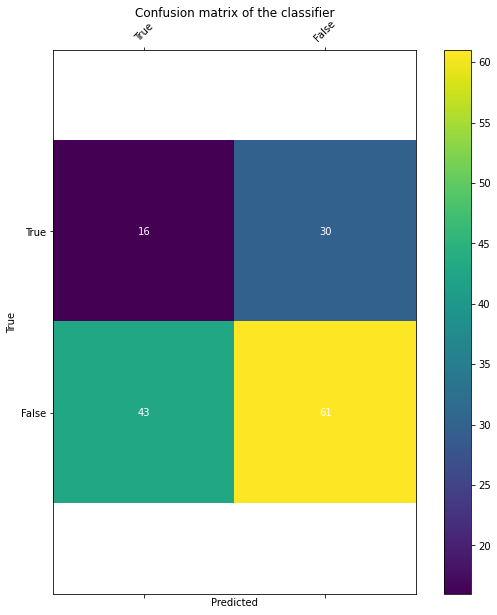

In [ ]:
#True = high, False = low
confusion_matrix_heatmap(true_y, predicted_y, labels)

Normalisation of the predictors did not improve the performance.

The accuracy statistics fell to 51.3% and the confusion matrix still shows that the model has troubles with indentifying True samples.

# Neural network model

Unfortunately, this model does not have a parameter that will take into consideration an imbalance in the samples.

In [ ]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.6857142857142857
Validation Accuracy 0.6266666666666667


In [ ]:
true_y = y_val
predicted_y = yv_p
labels = [True, False]

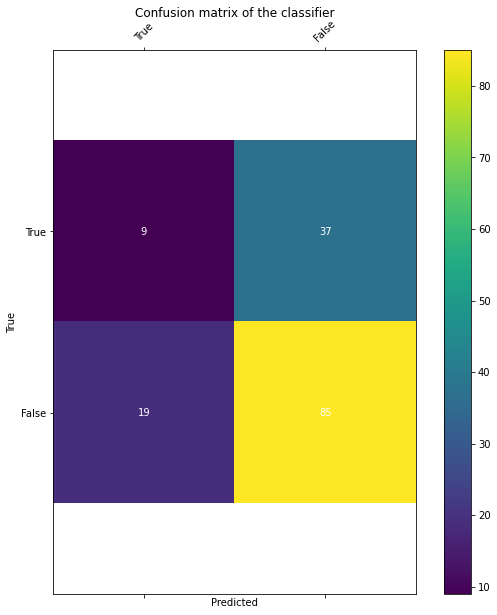

In [ ]:
#True = high, False = low
confusion_matrix_heatmap(true_y, predicted_y, labels)

The accuracy statistics show that the Neural Network model accurately predicts the label 62.7% of the time.

However, by a closer inspection of the confusion matrix, the model assigns a False label to the majority of samples. This means that the model does not know how to classify True samples. This is understandable as there are fewer True samples to train on so the model has less opporunities to learn about what to look out for in the True samples.

Next, I will normalise the predictors to see if the performance improves.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.6857142857142857
Validation Accuracy 0.6266666666666667


In [ ]:
true_y = y_val
predicted_y = yv_p
labels = [True, False]

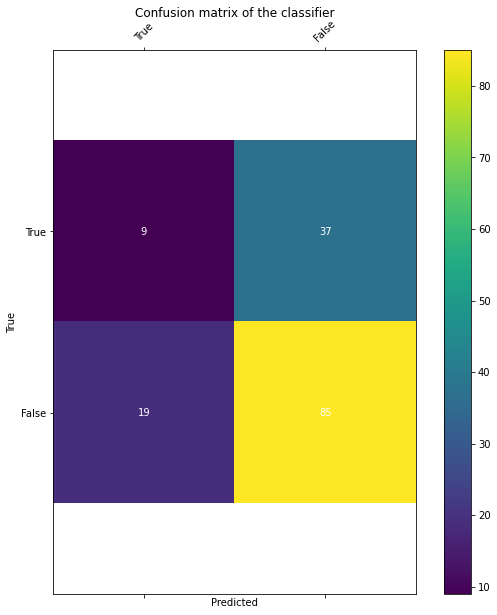

In [ ]:
#True = high, False = low
confusion_matrix_heatmap(true_y, predicted_y, labels)

Normalisation of the predictors did not improve the performance.

Both accuracy statistics and the confusion matrix remain unchanged.

<a id='P8'>

# 8 Conclusions

In conclusion, 3 of the models reached an accuracy rate of above 60%, i.e. Support vector machine (SVM) with normalised predictors, Gaussian Process Classification (GPC), and Neural network model. However, these models all assigned one label to the majority of the samples. Neither of GPC and NN models had a parameter that would take into consideration an imbalance in the samples. Therefore, fewer True samples meant the models had less opporunities to learn about what to look out for in the True samples. As a result, they assigned a False label to the majority of the samples as the models were more familiar with identifying False samples. In the case of the SVM model, despite taking into consideration the imbalance in the True and False samples, the model was unable to recognise True samples so instead it classified most samples as False.

The models that best distinguished between 'High' and 'Low' samples are Support vector machine (SVM) and Linear Support vector machine with normalised predictors. Each model predicted the correct labels with 53.3% and 58% accuracy respectively. Even though the accuracy is not as high, the confusion matrices show that both models could distinguish between 'High' and 'Low' samples.

To improve the solution to this problem, the number of samples used to train each model should be increased. This would enable each model to familiarise itself with more cases which would improve the decision boundry and in turn improve the accuracy.

Another way to improve the solution to this problem would be by doing more reading into the existing literature that dealt with ML and sound data. This would give an insight into the type of features one should focus on during the preprocessing and transformation stage which would eliminate the extraction of unnecessary features. As a result, each model would be trained on more meaningful features that could possibly make the classification easier resulting in more accurate predictions.
